# NeRF 실습자료

8월 22일 AI Expert 과정을 위해 제작된 colab입니다.
본 자료에서는 NeRF의 기초 및 활용에 대해 탐구합니다. NeRF에 관한 이론적 배경은 다음 논문을 참고해주세요. [Implicit Neural Activations with Periodic Activation Functions](https://arxiv.org/pdf/2210.00379.pdf).

본 실습은 다음의 순서로 구성되어 있습니다.
* TinyNeRF
* NeRFStudio
* ThreeStudio

**본 코랩 파일을 본인 계정의 구글 드라이브에 저장하시면 수정 후 저장이 가능합니다: 메뉴바의 File --> Save a copy in Drive**

**GPU를 활성화하였는지 확인해주세요: 메뉴바의 Edit --> Notebook Setting --> T4 GPU 선택**

# 1. TinyNeRF

빠른 학습 및 시각화를 위해 성능을 낮춘 NeRF 모델
* 기존 NeRF에 비해 20배가량의 적은 파라미터
* 5D input이 view direction을 포함하지 않음
* Hierarchical Sampling을 진행하지 않음

In [1]:
import os,sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2023-08-22 04:36:05--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-08-22 04:36:05--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  7.39MB/s    in 1.6s    

2023-08-22 04:36:07 (7.39 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


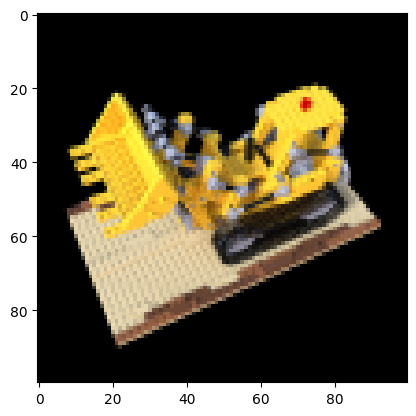

In [2]:
#Search for GPU to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Load in data
rawData = np.load("tiny_nerf_data.npz")
images = rawData["images"]
poses = rawData["poses"]
focal = rawData["focal"]
H, W = images.shape[1:3]
H = int(H)
W = int(W)
print(images.shape, poses.shape, focal)

testimg, testpose = images[99], poses[99]
plt.imshow(testimg)
plt.show()
images = torch.Tensor(images).to(device)
poses = torch.Tensor(poses).to(device)
testimg = torch.Tensor(testimg).to(device)
testpose = torch.Tensor(testpose).to(device)

In [3]:
def get_rays(H, W, focal, pose):
  i, j = torch.meshgrid(
      torch.arange(W, dtype=torch.float32),
      torch.arange(H, dtype=torch.float32)
      )
  i = i.t()
  j = j.t()
  dirs = torch.stack(
      [(i-W*0.5)/focal,
       -(j-H*0.5)/focal,
       -torch.ones_like(i)], -1).to(device)
  rays_d = torch.sum(dirs[..., np.newaxis, :] * pose[:3, :3], -1)
  rays_o = pose[:3,-1].expand(rays_d.shape)
  return rays_o, rays_d

In [4]:
def positional_encoder(x, L_embed=6):
  rets = [x]
  for i in range(L_embed):
    for fn in [torch.sin, torch.cos]:
      rets.append(fn(2.**i *x))#(2^i)*x
  return torch.cat(rets, -1)

def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  cumprod = torch.cumprod(tensor, -1)
  cumprod = torch.roll(cumprod, 1, -1)
  cumprod[..., 0] = 1.
  return cumprod

def render(model, rays_o, rays_d, near, far, n_samples, rand=False):
  def batchify(fn, chunk=1024*32):
      return lambda inputs: torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

  z = torch.linspace(near, far, n_samples).to(device)
  if rand:
    mids = 0.5 * (z[..., 1:] + z[...,:-1])
    upper = torch.cat([mids, z[...,-1:]], -1)
    lower = torch.cat([z[...,:1], mids], -1)
    t_rand = torch.rand(z.shape).to(device)
    z = lower + (upper-lower)*t_rand

  points = rays_o[..., None,:] + rays_d[..., None,:] * z[...,:,None]

  flat_points = torch.reshape(points, [-1, points.shape[-1]])
  flat_points = positional_encoder(flat_points)
  raw = batchify(model)(flat_points)
  raw = torch.reshape(raw, list(points.shape[:-1]) + [4])

  #Compute opacitices and color
  sigma = F.relu(raw[..., 3])
  rgb = torch.sigmoid(raw[..., :3])

  #Volume Rendering
  one_e_10 = torch.tensor([1e10], dtype=rays_o.dtype).to(device)
  dists = torch.cat((z[..., 1:] - z[..., :-1],
                  one_e_10.expand(z[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[...,None]* rgb).sum(dim=-2)
  depth_map = (weights * z).sum(dim=-1)
  acc_map = weights.sum(dim=-1)
  return rgb_map, depth_map, acc_map


In [5]:
#helper functions
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.])).to(device)

def train(model, optimizer, n_iters = 3001):
  #Track loss over time for graphing
  psnrs = []
  iternums = []
  plot_step = 500
  n_samples = 64
  for i in range(n_iters):
    #Choose random image and use it for training
    images_idx = np.random.randint(images.shape[0])
    target = images[images_idx]
    pose = poses[images_idx]

    #Core optimizer loop
    rays_o, rays_d = get_rays(H, W, focal, pose)
    rgb, disp, acc = render(model, rays_o, rays_d, near=2., far=6., n_samples=n_samples, rand=True)
    optimizer.zero_grad()
    image_loss = torch.nn.functional.mse_loss(rgb, target)
    image_loss.backward()
    optimizer.step()

    if i%plot_step==0:
      #Render shown image above as model begins to learn
      with torch.no_grad():
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render(model, rays_o, rays_d, near=2., far=6., n_samples=n_samples)
        loss = torch.nn.functional.mse_loss(rgb, testimg)
        psnr = mse2psnr(loss).cpu()

        psnrs.append(psnr)
        iternums.append(i)

        plt.figure(figsize=(10,5))
        plt.subplot(121)
        #copy from gpu memory to cpu
        picture = rgb.cpu()
        plt.imshow(picture)
        plt.title(f'Iterations: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

In [6]:
class VeryTinyNerfModel(torch.nn.Module):
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


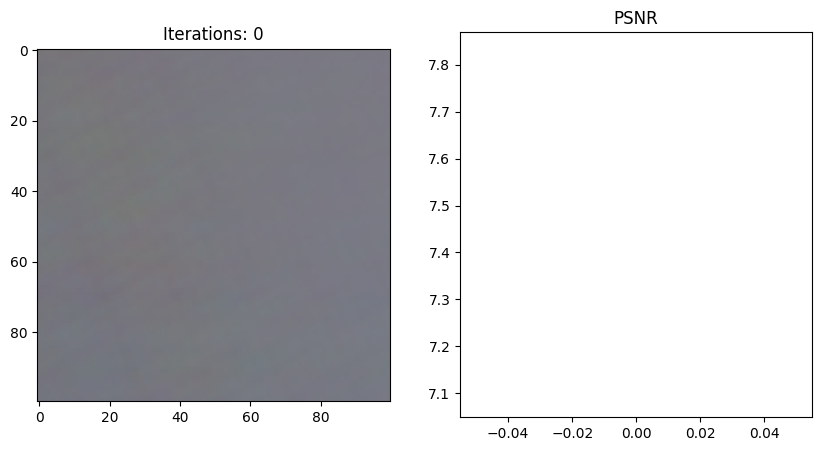

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


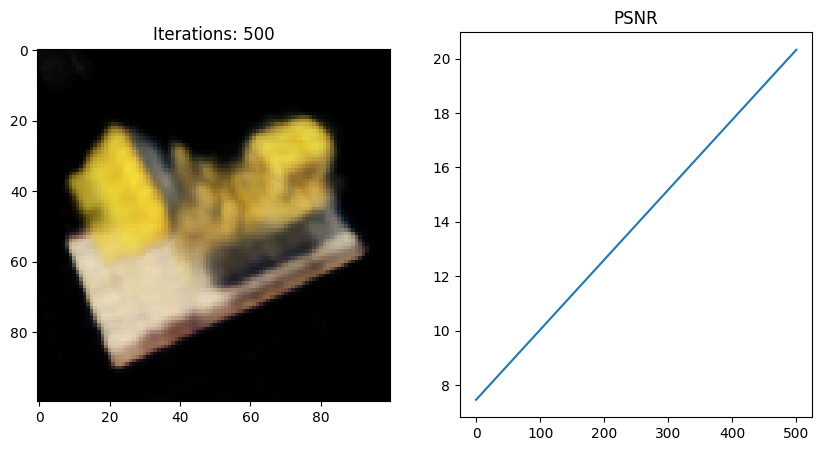

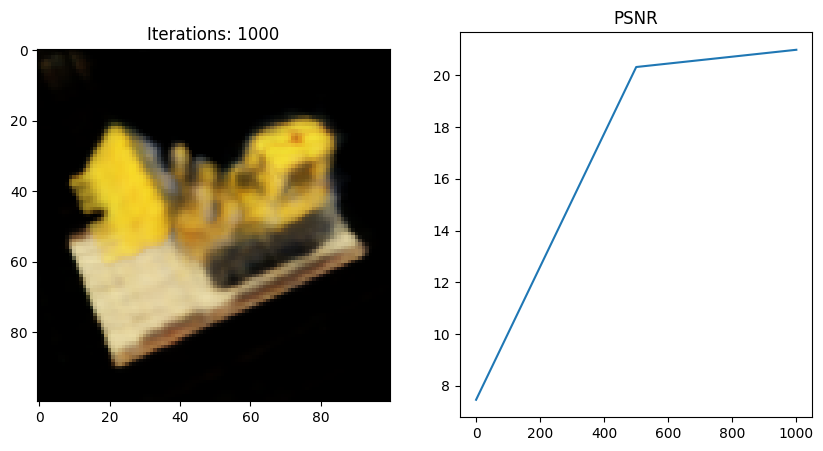

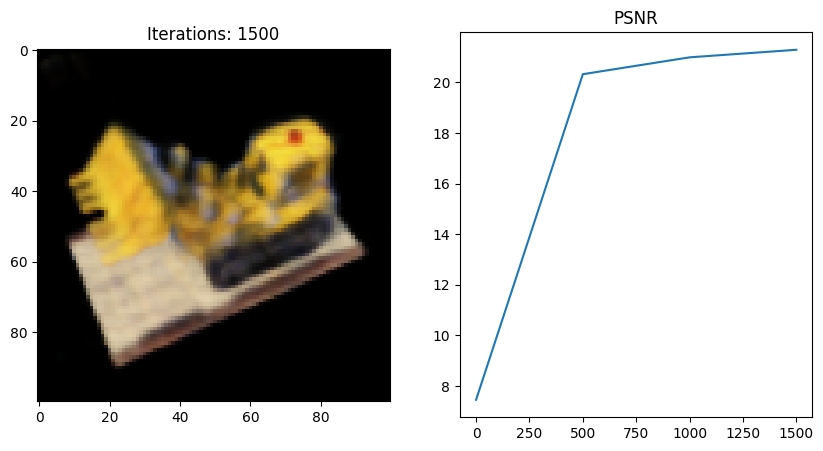

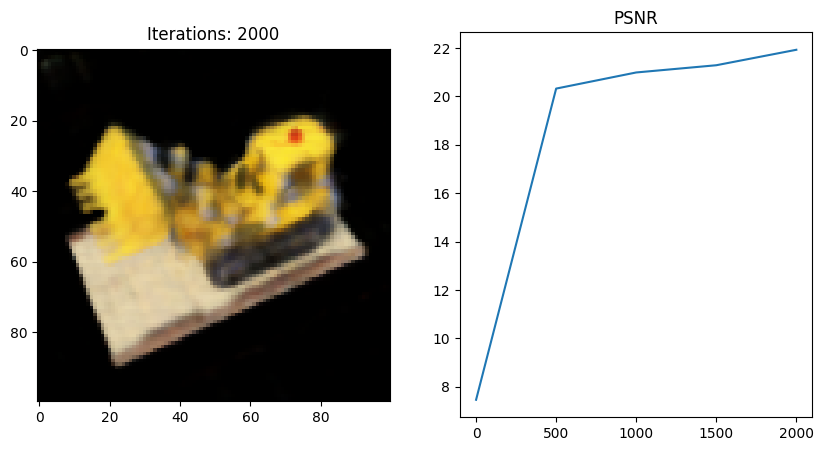

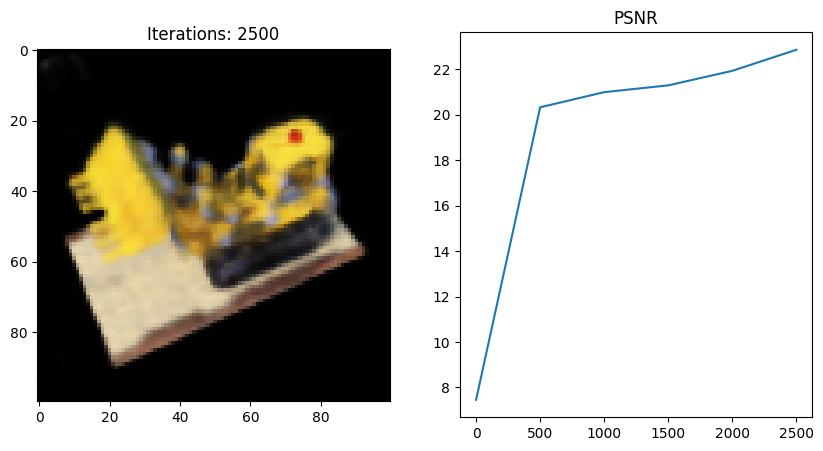

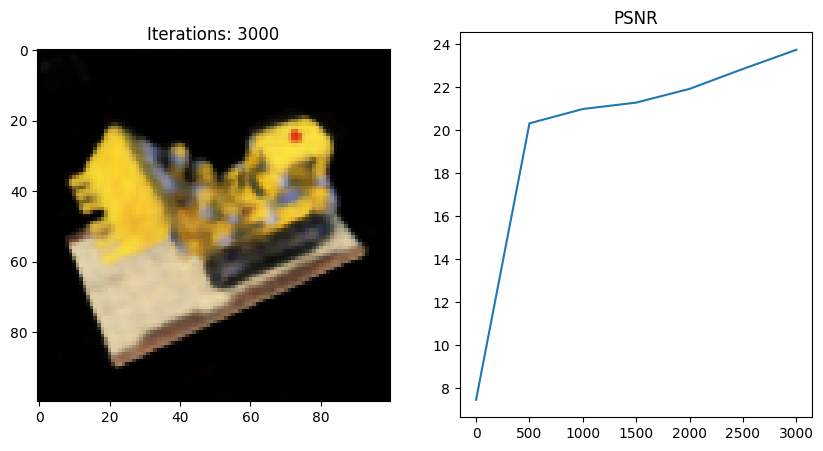

In [7]:
#Run all the actual code
nerf = VeryTinyNerfModel()
nerf = nn.DataParallel(nerf).to(device)
optimizer = torch.optim.Adam(nerf.parameters(), lr=5e-3, eps = 1e-7)
train(nerf, optimizer)

In [8]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=torch.float32) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs).cuda()
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render(nerf, rays_o, rays_d, near=2., far=6., n_samples=64)
    img = np.clip(rgb.cpu().detach().numpy(),0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

#2. NeRFStudio

다양한 NeRF 모델을 쉽게 활용할 수 있도록 제작된 플랫폼.

* 여러 종류의 NeRF 모델 (dynamic nerf, editing nerf, 3d diffusion model, fast nerf)을 포함
* 강력한 Visualizer를 지원하여, 원하는 뷰 이미지를 간편하게 렌더링 가능
* Dataloader, ray sampler, encoder 등, nerf의 각 모듈을 손쉽게 수정할 수 있어서 새로운 모델 개발 용이

In [9]:
#@markdown Install Nerfstudio and Dependencies (~8 min)
%cd /content/
!pip install --upgrade pip
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 --extra-index-url https://download.pytorch.org/whl/cu118

# Installing TinyCuda
%cd /content/
!gdown "https://drive.google.com/u/1/uc?id=1-7x7qQfB7bIw2zV4Lr6-yhvMpjXC84Q5&confirm=t"
!pip install tinycudann-1.7-cp310-cp310-linux_x86_64.whl

# Installing COLMAP
%cd /content/
!gdown "https://drive.google.com/u/0/uc?id=15WngFRNar_b8CaPR5R-hvQ3eAnlyk_SL&confirm=t"
!sudo apt-get install \
    build-essential \
    libboost-program-options-dev \
    libboost-filesystem-dev \
    libboost-graph-dev \
    libboost-system-dev \
    libboost-test-dev \
    libeigen3-dev \
    libflann-dev \
    libfreeimage-dev \
    libmetis-dev \
    libgoogle-glog-dev \
    libgflags-dev \
    libsqlite3-dev \
    libglew-dev \
    qtbase5-dev \
    libqt5opengl5-dev \
    libcgal-dev \
    libceres-dev
!unzip -o local.zip -d /usr/
!chmod +x /usr/local/bin/colmap

# Install nerfstudio
%cd /content/
!pip install tensorboard<2.13
!pip install git+https://github.com/nerfstudio-project/nerfstudio.git

/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
/content
Downloading...
From: https://drive.google.com/u/1/uc?id=1-7x7qQfB7bIw2zV4Lr6-yhvMpjXC84Q5&confirm=t
To: /content/tinycudann-1.7-cp310-cp310-linux_x86_64.whl
100% 31.2M/31.2M [00:00<00:00, 72.6MB/s]
Processing ./tinycudann-1.7-cp310-cp310-linux_x86_64.whl
/content
Downloading...
From: https://drive.google.com/u/0/uc?id=15WngFRNar_b8CaPR5R-hvQ3eAnlyk_SL&confirm=t
To: /content/local.zip
100% 31.7M/31.7M [00:00<00:00, 57.2MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libboost-filesystem-dev is already the newest version (1.74.0.3ubuntu7).
libboost-filesyst

In [10]:
#@markdown <h1> Downloading and Processing Data</h1>
#@markdown <h3>Pick the preset scene or upload your own images/video</h3>
import os
import glob
from google.colab import files
from IPython.core.display import display, HTML

scene = '\uD83D\uDE9C dozer' #@param ['🖼 poster', '🚜 dozer', '🌄 desolation', '📤 upload your images' , '🎥 upload your own video', '🔺 upload Polycam data', '💽 upload your own Record3D data']
scene = ' '.join(scene.split(' ')[1:])

if scene == "upload Polycam data":
    %cd /content/
    !mkdir -p /content/data/nerfstudio/custom_data
    %cd /content/data/nerfstudio/custom_data/
    uploaded = files.upload()
    dir = os.getcwd()
    if len(uploaded.keys()) > 1:
        print("ERROR, upload a single .zip file when processing Polycam data")
    dataset_dir = [os.path.join(dir, f) for f in uploaded.keys()][0]
    !ns-process-data polycam --data $dataset_dir --output-dir /content/data/nerfstudio/custom_data/
    scene = "custom_data"
elif scene == 'upload your own Record3D data':
    display(HTML('<h3>Zip your Record3D folder, and upload.</h3>'))
    display(HTML('<h3>More information on Record3D can be found <a href="https://docs.nerf.studio/en/latest/quickstart/custom_dataset.html#record3d-capture" target="_blank">here</a>.</h3>'))
    %cd /content/
    !mkdir -p /content/data/nerfstudio/custom_data
    %cd /content/data/nerfstudio/custom_data/
    uploaded = files.upload()
    dir = os.getcwd()
    preupload_datasets = [os.path.join(dir, f) for f in uploaded.keys()]
    record_3d_zipfile = preupload_datasets[0]
    !unzip $record_3d_zipfile -d /content/data/nerfstudio/custom_data
    custom_data_directory = glob.glob('/content/data/nerfstudio/custom_data/*')[0]
    !ns-process-data record3d --data $custom_data_directory --output-dir /content/data/nerfstudio/custom_data/
    scene = "custom_data"
elif scene in ['upload your images', 'upload your own video']:
    display(HTML('<h3>Select your custom data</h3>'))
    display(HTML('<p/>You can select multiple images by pressing ctrl, cmd or shift and click.<p>'))
    display(HTML('<p/>Note: This may take time, especially on higher resolution inputs, so we recommend to download dataset after creation.<p>'))
    !mkdir -p /content/data/nerfstudio/custom_data
    if scene == 'upload your images':
        !mkdir -p /content/data/nerfstudio/custom_data/raw_images
        %cd /content/data/nerfstudio/custom_data/raw_images
        uploaded = files.upload()
        dir = os.getcwd()
    else:
        %cd /content/data/nerfstudio/custom_data/
        uploaded = files.upload()
        dir = os.getcwd()
    preupload_datasets = [os.path.join(dir, f) for f in uploaded.keys()]
    del uploaded
    %cd /content/

    if scene == 'upload your images':
        !ns-process-data images --data /content/data/nerfstudio/custom_data/raw_images --output-dir /content/data/nerfstudio/custom_data/
    else:
        video_path = preupload_datasets[0]
        !ns-process-data video --data $video_path --output-dir /content/data/nerfstudio/custom_data/

    scene = "custom_data"
else:
    %cd /content/
    !ns-download-data nerfstudio --capture-name=$scene

print("Data Processing Succeeded!")

/content
2023-08-22 04:59:30.104898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Downloading...
From: https://drive.google.com/uc?id=1jQJPz5PhzTH--LOcCxvfzV_SDLEp1de3
To: /content/data/nerfstudio/dozer.zip
100% 1.35G/1.35G [00:19<00:00, 67.9MB/s]
Data Processing Succeeded!


In [16]:
#@markdown <h1>Set up and Start Viewer</h1>

%cd /content

# Install localtunnel
# We are using localtunnel https://github.com/localtunnel/localtunnel but ngrok could also be used
!npm install -g localtunnel

# Tunnel port 7007, the default for
!rm url.txt 2> /dev/null
get_ipython().system_raw('lt --port 7007 >> url.txt 2>&1 &')

import time
time.sleep(3) # the previous command needs time to write to url.txt


with open('url.txt') as f:
  lines = f.readlines()
websocket_url = lines[0].split(": ")[1].strip().replace("https", "wss")
# from nerfstudio.utils.io import load_from_json
# from pathlib import Path
# json_filename = "nerfstudio/nerfstudio/viewer/app/package.json"
# version = load_from_json(Path(json_filename))["version"]
url = f"https://viewer.nerf.studio/?websocket_url={websocket_url}"
print(url)
print("You may need to click Refresh Page after you start training!")
from IPython import display
display.IFrame(src=url, height=800, width="100%")

/content
/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 1.435s


   ╭───────────────────────────────────────────────────────────────╮
   │                                                               │
   │      New major version of npm available! 6.14.8 → 9.8.1       │
   │   Changelog: https://github.com/npm/cli/releases/tag/v9.8.1   │
   │               Run npm install -g npm to update!               │
   │                                                               │
   ╰───────────────────────────────────────────────────────────────╯

https://viewer.nerf.studio/?websocket_url=wss://heavy-hotels-grin.loca.lt
You may need to click Refresh Page after you start training!


In [17]:
#@markdown <h1>Start Training</h1>

%cd /content
if os.path.exists(f"data/nerfstudio/{scene}/transforms.json"):
    !ns-train nerfacto --viewer.websocket-port 7007 nerfstudio-data --data data/nerfstudio/$scene --downscale-factor 4
else:
    from IPython.core.display import display, HTML
    display(HTML('<h3 style="color:red">Error: Data processing did not complete</h3>'))
    display(HTML('<h3>Please re-run `Downloading and Processing Data`, or view the FAQ for more info.</h3>'))

/content
2023-08-22 05:45:12.579965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
──────────────────────────────────────────────────────── Config ────────────────────────────────────────────────────────
TrainerConfig(
    _target=<class 'nerfstudio.engine.trainer.Trainer'>,
    output_dir=PosixPath('outputs'),
    method_name='nerfacto',
    experiment_name=None,
    project_name='nerfstudio-project',
    timestamp='2023-08-22_054518',
    machine=MachineConfig(seed=42, num_devices=1, num_machines=1, machine_rank=0, dist_url='auto', device_type='cuda'),
    logging=LoggingConfig(
        relative_log_dir=PosixPath('.'),
        steps_per_log=10,
        max_buffer_size=20,
        local_writer=LocalWriterConfig(
            _target=<class 'nerfstudio.utils.writer.LocalWriter'>,
            enable=True,
            stats_to_track=(
                <EventName.ITER_TRAIN_TIME: 'Train Iter (time)'>,
                <EventName.TRAIN_RAYS_PE

In [18]:
!ns-render camera-path --load-config outputs/unnamed/nerfacto/2023-08-22_050750/config.yml --camera-path-filename outputs/unnamed/nerfacto/2023-08-22_050750/camera_paths/2023-08-22_050750.json --output-path renders/2023-08-22_050750/2023-08-22_050750.mp4

2023-08-22 05:55:02.915831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading latest checkpoint from load_dir
✅ Done loading checkpoint from outputs/unnamed/nerfacto/2023-08-22_050750/nerfstudio_models/step-000028000.ckpt
Traceback (most recent call last):
  File "/usr/local/bin/ns-render", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/nerfstudio/scripts/render.py", line 595, in entrypoint
    tyro.cli(Commands).main()
  File "/usr/local/lib/python3.10/dist-packages/nerfstudio/scripts/render.py", line 363, in main
    with open(self.camera_path_filename, "r", encoding="utf-8") as f:
FileNotFoundError: [Errno 2] No such file or directory: 'outputs/unnamed/nerfacto/2023-08-22_050750/camera_paths/2023-08-22_050750.json'


In [ ]:
!ns-render camera-path --load-config outputs/unnamed/nerfacto/2023-08-21_125010/config.yml --camera-path-filename outputs/unnamed/nerfacto/2023-08-21_125010/camera_paths/2023-08-21_125010.json --output-path renders/2023-08-21_125010/2023-08-21_125010.mp4

In [ ]:
#@title # Render Video { vertical-output: true }
#@markdown <h3>Export the camera path from within the viewer, then run this cell.</h3>
#@markdown <h5>The rendered video should be at renders/output.mp4!</h5>


base_dir = "/content/outputs/unnamed/nerfacto/"
training_run_dir = base_dir + os.listdir(base_dir)[0]

from IPython.core.display import display, HTML
display(HTML('<h3>Upload the camera path JSON.</h3>'))
%cd $training_run_dir
uploaded = files.upload()
uploaded_camera_path_filename = list(uploaded.keys())[0]

config_filename = training_run_dir + "/config.yml"
camera_path_filename = training_run_dir + "/" + uploaded_camera_path_filename
camera_path_filename = camera_path_filename.replace(" ", "\\ ").replace("(", "\\(").replace(")", "\\)")

%cd /content/
!ns-render camera-path --load-config $config_filename --camera-path-filename $camera_path_filename --output-path renders/output.mp4

[19:48:48] Skipping 0 files in dataset split train.                                          ]8;id=527413;file:///content/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=243595;file:///content/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#91\91]8;;\
           Skipping 0 files in dataset split test.                                           ]8;id=109270;file:///content/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=464675;file:///content/nerfstudio/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#91\91]8;;\
Loading data batch ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
/usr/local/lib/python3.7/site-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Plea

In [19]:
#@title # 중지된 training 재개
base_dir = "/content/outputs/unnamed/nerfacto/"
training_run_dir = base_dir + os.listdir(base_dir)[0] + '/nerfstudio_models'

%cd /content/
!ns-train nerfacto --load-dir {training_run_dir} --viewer.websocket-port 7007 nerfstudio-data --data data/nerfstudio/$scene --downscale-factor 4

/content
2023-08-22 05:55:26.368654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
──────────────────────────────────────────────────────── Config ────────────────────────────────────────────────────────
TrainerConfig(
    _target=<class 'nerfstudio.engine.trainer.Trainer'>,
    output_dir=PosixPath('outputs'),
    method_name='nerfacto',
    experiment_name=None,
    project_name='nerfstudio-project',
    timestamp='2023-08-22_055534',
    machine=MachineConfig(seed=42, num_devices=1, num_machines=1, machine_rank=0, dist_url='auto', device_type='cuda'),
    logging=LoggingConfig(
        relative_log_dir=PosixPath('.'),
        steps_per_log=10,
        max_buffer_size=20,
        local_writer=LocalWriterConfig(
            _target=<class 'nerfstudio.utils.writer.LocalWriter'>,
            enable=True,
            stats_to_track=(
                <EventName.ITER_TRAIN_TIME: 'Train Iter (time)'>,
                <EventName.TRAIN_RAYS_PE

### NeRFStudio를 이용한 다양한 모델의 활용
* nerfacto는 여러 논문에서 component를 조합하여 만든 pipeline임
* nerfstudio는 nerfacto 이외에 다양한 모델들을 지원
  - Instant-NGP
  - [Instruct-NeRF2NeRF](https://docs.nerf.studio/en/latest/nerfology/methods/in2n.html)
  - K-Planes
  - [LERF](https://docs.nerf.studio/en/latest/nerfology/methods/lerf.html)
  - Mip-NeRF
  - NeRF
  - Nerfacto
  - Nerfbusters
  - NeRFPlayer
  - Tetra-NeRF
  - TensoRF
  - [Generfacto](https://docs.nerf.studio/en/latest/nerfology/methods/generfacto.html)

#### Training TensoRF

In [20]:
!ns-train tensorf --viewer.websocket-port 7007 nerfstudio-data --data data/nerfstudio/$scene --downscale-factor 4

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
-----------------------------------------------------------------------------------                  
7600 (25.33%)       249.987 ms           1 h, 33 m, 19 s      16.39 K                                
7610 (25.37%)       247.999 ms           1 h, 32 m, 32 s      16.52 K                                
7620 (25.40%)       248.164 ms           1 h, 32 m, 33 s      16.51 K                                
7630 (25.43%)       250.910 ms           1 h, 33 m, 32 s      16.33 K                                
7640 (25.47%)       255.913 ms           1 h, 35 m, 22 s      16.01 K                                
7650 (25.50%)       258.666 ms           1 h, 36 m, 21 s      15.84 K                                
7660 (25.53%)       253.560 ms           1 h, 34 m, 24 s      16.16 K                                
7670 (25.57%)       247.963 ms           1 h, 32 m, 17 s      16.52 K                                
7680 (25.60%)       248.639 ms           1 h, 

# 3. ThreeStudio

#### Clone threestudio repo

In [21]:
!git clone https://github.com/threestudio-project/threestudio.git
%cd threestudio

Cloning into 'threestudio'...
remote: Enumerating objects: 5689, done.
remote: Counting objects: 100% (3212/3212), done.
remote: Compressing objects: 100% (768/768), done.
remote: Total 5689 (delta 2861), reused 2557 (delta 2444), pack-reused 2477
Receiving objects: 100% (5689/5689), 16.87 MiB | 16.12 MiB/s, done.
Resolving deltas: 100% (4241/4241), done.
/content/threestudio


#### Install Dependencies

In [22]:
!pip install ninja
!pip install lightning==2.0.0 omegaconf==2.3.0 jaxtyping typeguard diffusers transformers accelerate opencv-python tensorboard matplotlib imageio imageio[ffmpeg] trimesh bitsandbytes sentencepiece safetensors huggingface_hub libigl xatlas networkx pysdf PyMCubes wandb torchmetrics controlnet_aux
!pip install einops kornia taming-transformers-rom1504 git+https://github.com/openai/CLIP.git # zero123
!pip install open3d plotly # mesh visualization
!pip install git+https://github.com/ashawkey/envlight.git
!pip install git+https://github.com/KAIR-BAIR/nerfacc.git@v0.5.2
!pip install git+https://github.com/NVlabs/nvdiffrast.git
!pip install git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.5 MB/s eta 0:00:00
  Obtaining dependency information for diffusers from https://files.pythonhosted.org/packages/24/4a/b45557513dfcfb6d69e5c138325a0d7431943792b662e482dcd886c11bb4/diffusers-0.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 17.4 MB/s eta 0:00:00
  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/70/f9/c381bcdd0c3829d723aa14eec8e75c6c377b4ca61ec68b8093d9f35fc7a7/accelerate-0.21.0-py3-none-any.whl.metadata
  Obtaining dependency information for bitsandbytes from https://files.pythonhosted.org/packages/1e/2c/af22cd797fc368a9f098ed03015730e6568b

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8bu93u0l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8bu93u0l
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for kornia from https://files.pythonhosted.org/packages/55/da/72cb83aa364ebb4d0109965e20c5d33d7063ccab15332c3fd0acfd5609c9/kornia-0.7.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 11.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=142eed583cd8aa4bf24de1330d7d82bce2c9f222c7bbeb16df4933f63a264d20
  Stored in directory: /tmp/pip-ephem-wheel-cache-69ytaldr/wheels/da/2b/4c/d6691

#### Login to HuggingFace

In [27]:
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: ··········
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Your token has been save

#### Generate 3D Model

In [28]:
prompt = "a zoomed out DSLR photo of a baby bunny sitting on top of a stack of pancakes"
!python launch.py --config configs/dreamfusion-sd.yaml --train --gpu 0 system.prompt_processor.prompt="$prompt" trainer.max_steps=1000 system.prompt_processor.spawn=false

2023-08-22 07:00:30.435267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
Global seed set to 0
[INFO] ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.
[INFO] Using 16bit Automatic Mixed Precision (AMP)
[INFO] GPU available: True (cuda), used: True
[INFO] TPU available: False, using: 0 TPU cores
[INFO] IPU available: False, using: 0 IPUs
[INFO] HPU available: False, using: 0 HPUs
[INFO] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[INFO] 
  | Name       | Type                           | Params
--------------------------------------------------------------
0 | geometry   | ImplicitVolume                 | 12.6 M
1 | m

#### Display the rendered Video

In [ ]:
from IPython.display import HTML
from base64 import b64encode
def display_video(video_path):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=1000 controls>
    <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

In [ ]:
# you will see the path to the saving directory at the end of the training logs
# replace save_dir below with that path
save_dir = 'path/to/save/dir'

import os
import glob
video_path = glob.glob(os.path.join(save_dir, "*-test.mp4"))[0]
display_video(video_path)

#### Extract the object mesh.

Here we use an empirical threshold value. You can also first try system.geometry.isosurface_threshold=auto and visualize it. Then you can manually adjust the threshold according to the automatically determined value shown in the logs. Increase it if there are too many floaters and decrease it if the geometry is incomplete.

The extraction process takes around 2 mins on T4.

In [ ]:
!python launch.py --config $save_dir/../configs/parsed.yaml --export --gpu 0 resume=$save_dir/../ckpts/last.ckpt system.exporter_type=mesh-exporter system.exporter.context_type=cuda system.geometry.isosurface_threshold=15.0